In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Created a custom covnet with 3 convolutional layers followed by 4 dense layers.Utilized techniques like batchprocessing, dropout,
# data augmentation(RandomContrast, RandomFlip(horizantal_and_vertical), RandomRotation as the dataset contained images taken from various
# different angles), earlystopping to help prevent overfitting.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dense, Dropout


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data_dir = r'pred images'
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.


2025-03-27 22:24:21.543663: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


2025-03-27 22:24:32.300664: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


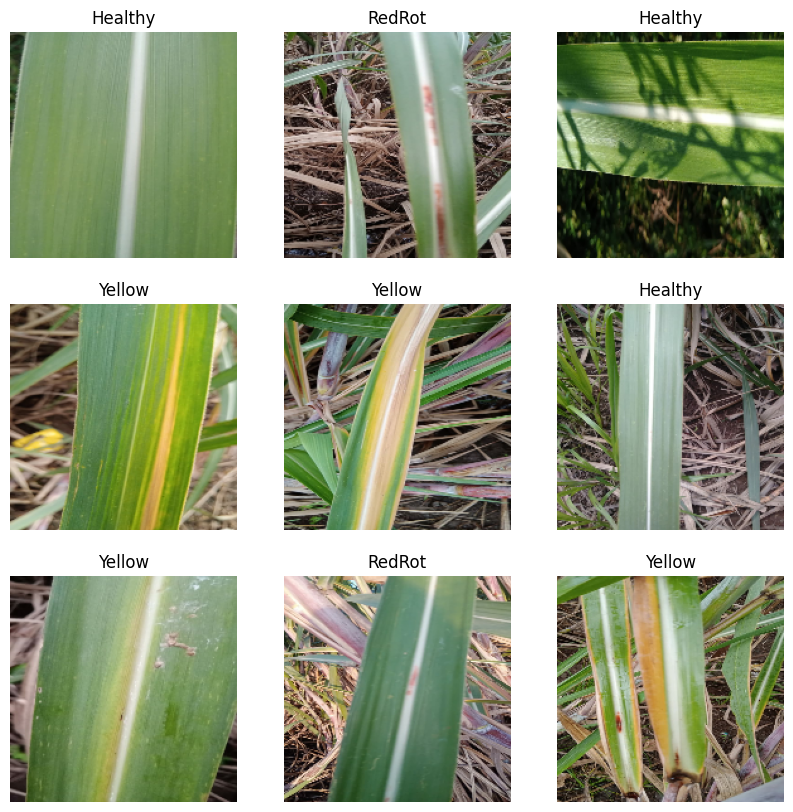

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[180, 180, 3]),
    
    RandomContrast(factor=0.10),
    RandomFlip(mode='horizontal_and_vertical'),
    RandomRotation(factor=0.10),    

    BatchNormalization(),  # Removed renorm=True
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    
    BatchNormalization(),  # Removed renorm=True
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    
    BatchNormalization(),  # Removed renorm=True
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),

    BatchNormalization(),  # Removed renorm=True
    Flatten(),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
     
    Dense(5, activation='softmax')
])

/home/sanskar_kesari/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_1               │ (None, 180, 180, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 180, 180, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,964,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             

 Total params: 4,268,177 (16.28 MB)

 Trainable params: 4,266,571 (16.28 MB)

 Non-trainable params: 1,606 (6.27 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.001  # You can set this to your preferred initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001  # Initial learning rate for the first 10 epochs
    elif 10 <= epoch < 20:
        return 0.0005  # Learning rate for epochs 10 to 19
    else:
        return 0.0001  # Learning rate for subsequent epochs

# Set up LearningRateScheduler and EarlyStopping callbacks
learning_rate_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Model training with epoch-wise learning rate decay and early stopping
epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[learning_rate_scheduler, early_stopping]
)

Epoch 1/40


/home/sanskar_kesari/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3457 - loss: 1.9552 - val_accuracy: 0.3909 - val_loss: 1.4261 - learning_rate: 0.0010
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4979 - loss: 1.4172 - val_accuracy: 0.5357 - val_loss: 1.2175 - learning_rate: 0.0010
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5683 - loss: 1.1636 - val_accuracy: 0.5060 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5863 - loss: 1.0862 - val_accuracy: 0.4583 - val_loss: 1.5319 - learning_rate: 0.0010
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6687 - loss: 0.9600 - val_accuracy: 0.6905 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6718 - loss: 0.8928 - val_accuracy: 0.7302 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6928 - loss: 0.8477 - val_accuracy: 0.76

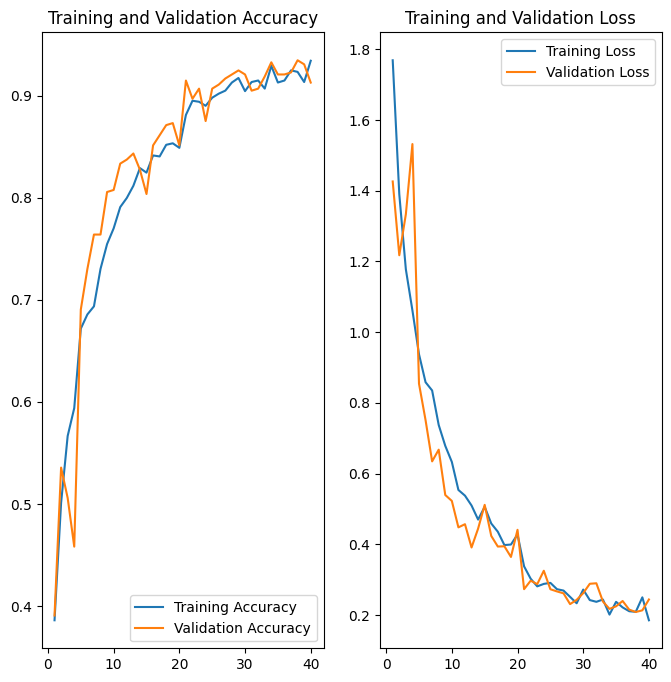

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)  # Use the actual number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# Save the trained model
model.save('sugarcane_disease_model.h5')

print("Model saved successfully as 'sugarcane_disease_model.h5'")


Model saved successfully as 'sugarcane_disease_model.h5'


In [19]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('sugarcane_disease_model.h5')
print("Model loaded successfully!")


Model loaded successfully!


In [20]:
import pickle

with open("sugarcane_disease_model.pkl", "wb") as f:
    pickle.dump(model, f)
